# Goals
This project focuses on four transportation modes: metro, RER, train, tramway.

For the project we need 3 main things:

* A database of all stops for each line. We only consider lines for the four aforementioned transporation modes. The database should include: ID, name, position, associated line.
* A database of all lines for the four aforementioned transporation modes. The database should include: ID, name, color in the network map, company, pictogram, geospatial data. The geospatial data should be a contiguous MultiLine. An analysis of the raw data showed that each line graph is not exactly connected, which is a problem.
* Shortest paths for each pair of stops belonging to the same line. This shortest path database will help building the exact path of a route (a route being an ordered sequence of stops).

# Download data from IDFM
We use [PRIM](https://prim.iledefrance-mobilites.fr) data. PRIM is the data hub for IDFM (Ile-de-France mobilité), the administration in charge of public transportation in Paris region.

### Stops and associated lines
This dataset lists all the lines in the Ile-de-France network and the stops served for each of these lines as in GTFS.

Found here: https://prim.iledefrance-mobilites.fr/en/jeux-de-donnees/arrets-lignes?staticDataSlug=arrets-lignes

### Alignments of the Ile-de-France rail network
This dataset is a geographical represenation of the rail network (metro, RER, trains, tramway, etc).

In [1]:
RAW_DATA_PATH="raw_data"

# Data on stops
STOPS_DATA_URL="https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/download/\?format=json"
STOPS_DATA_FILE_PATH="raw_data/stops.json"

# Data on network (GeoJSON routes)
NETWORK_DATA_URL="https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/\?format=json"
NETWORK_DATA_FILE_PATH="raw_data/network.json"


In [2]:
# Download data
!mkdir -p RAW_DATA_PATH
!wget $STOPS_DATA_URL -O $STOPS_DATA_FILE_PATH
!wget $NETWORK_DATA_URL -O $NETWORK_DATA_FILE_PATH

--2023-12-22 12:10:24--  https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/download/?format=json
Resolving data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)... 34.249.199.226, 34.248.20.69
Connecting to data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘raw_data/stops.json’

raw_data/stops.json     [      <=>           ]  73,56M  4,50MB/s    in 17s     

2023-12-22 12:10:41 (4,36 MB/s) - ‘raw_data/stops.json’ saved [77130874]

--2023-12-22 12:10:41--  https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=json
Resolving data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)... 34.248.20.69, 34.249.199.226
Connecting to data.iledefrance-mobilites.fr (data.iledefrance-mobilites.fr)|34.248.20.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: u

# Load data

In [3]:
import geopandas as gpd
import pandas as pd
import json
from shapely import LineString, Point, MultiPoint

### Network

In [4]:
# Load network json data into a Pandas dataframe
with open(NETWORK_DATA_FILE_PATH, 'r') as data:
    network = pd.json_normalize(json.load(data))
network.head()

,datasetid,recordid,record_timestamp,fields.geo_point_2d,fields.shape_leng,fields.reseau,fields.picto_final,fields.idrefliga,fields.colourweb_hexa,fields.mode,...,fields.train,fields.tramway,fields.indice_lig,fields.val,fields.extcode,fields.metro,fields.exploitant,fields.date_mes,geometry.type,geometry.coordinates
0,traces-du-reseau-ferre-idf,f2cd0f720deb9f119603813ba5fb313bde1e97b5,2023-12-06T15:35:03.253Z,"[48.70559737256437, 2.2254005317983836]",2050.609363,RER B,https://data.iledefrance-mobilites.fr/explore/...,A01857,5091cb,RER,...,0,0,B,0,810:B,0,RATP,1854-07-28T00:00:00Z,Point,"[2.2254005317983836, 48.70559737256437]"
1,traces-du-reseau-ferre-idf,3602c8cebf4f0af8d19d69bee2c47f33785c84bc,2023-12-06T15:35:03.253Z,"[48.36147836885303, 2.0460686780825]",3552.934338,GRANDES LIGNES,picto_intermediaire/300,A02179,aaaaaa,TER,...,1,0,GL,0,800:TER,0,SNCF,1843-05-05T00:00:00Z,Point,"[2.0460686780825, 48.36147836885303]"
2,traces-du-reseau-ferre-idf,94b68d7557a4637b4acd6e1d600d21669bca71c3,2023-12-06T15:35:03.253Z,"[48.30309453538505, 2.680472509812245]",7769.496216,PARIS SUD EST,https://data.iledefrance-mobilites.fr/explore/...,A01845,f49fb3,TRAIN,...,1,0,R,0,800:R,0,SNCF,1860-08-14T00:00:00Z,Point,"[2.680472509812245, 48.30309453538505]"
3,traces-du-reseau-ferre-idf,081393c9c1a3ae8eb731e96d0b53994aaf2ccafa,2023-12-06T15:35:03.253Z,"[48.5994750985704, 2.4600447140917345]",1535.935980,RER D,https://data.iledefrance-mobilites.fr/explore/...,A01842,008b5b,RER,...,0,0,D,0,800:D,0,SNCF,1995-09-24T00:00:00Z,Point,"[2.4600447140917345, 48.5994750985704]"
4,traces-du-reseau-ferre-idf,4d0d1a0ab2d3c3aeee8860517a68edbf0eee079a,2023-12-06T15:35:03.253Z,"[48.59208789321902, 2.9521464036033813]",11002.645773,PARIS EST,https://data.iledefrance-mobilites.fr/explore/...,A01844,f58f53,TRAIN,...,1,0,P,0,800:P,0,SNCF,1857-02-09T00:00:00Z,Point,"[2.9521464036033813, 48.59208789321902]"


In [5]:
# Select relevant fields
network_relevant_fields = {
    "fields.idrefligc": 'short_id',
    "fields.geo_shape.coordinates": 'geometry',
    "fields.res_com": 'name',
    "fields.exploitant": 'company',
    "fields.mode": 'transportation_type',
    "fields.colourweb_hexa": 'color',
    "fields.idf": 'in_idf',
    "fields.picto_final": 'picture_url'
}
network = network[list(network_relevant_fields.keys())]
network = network.rename(columns=network_relevant_fields)

network['short_id'] = network['short_id'].astype('string')
network['name'] = network['name'].astype('string')
network['company'] = network['company'].astype('string')
network['transportation_type'] = network['transportation_type'].astype('string')
network['color'] = network['color'].astype('string')
network['in_idf'] = network['in_idf'].astype('bool')
network['picture_url'] = network['picture_url'].astype('string')

network.head()

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01743,"[[2.212262378017492, 48.705968983887125], [2.2...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...
1,C01857,"[[2.0322397733867, 48.34841601331182], [2.0322...",TER CENTRE-VDL,SNCF,TER,aaaaaa,True,picto_intermediaire/300
2,C01731,"[[2.692480190584066, 48.33268364377388], [2.69...",TRAIN R,SNCF,TRAIN,f49fb3,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01728,"[[2.461550180897488, 48.59281218940513], [2.46...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01730,"[[3.012012142480831, 48.561947849088995], [3.0...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...


In [6]:
# Only keep select transportation modes
network = network[network.transportation_type.isin(['TRAMWAY', 'RER', 'METRO', 'TRAIN'])]

# Filter out row with missing data
network = network[network.color.notna()]

In [7]:
# Convert to GeoDataFrame
network.geometry = network.geometry.apply(lambda x: LineString(x))
network = gpd.GeoDataFrame(network, geometry='geometry')
network

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01743,"LINESTRING (2.21226 48.70597, 2.21246 48.70594...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...
2,C01731,"LINESTRING (2.69248 48.33268, 2.69139 48.33228...",TRAIN R,SNCF,TRAIN,f49fb3,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01728,"LINESTRING (2.46155 48.59281, 2.46129 48.59300...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01730,"LINESTRING (3.01201 48.56195, 3.01158 48.56227...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...
5,C01730,"LINESTRING (3.07563 49.13547, 3.07596 49.13832...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...
...,...,...,...,...,...,...,...,...
1638,C02528,"LINESTRING (2.25958 48.76556, 2.25580 48.76604...",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
1639,C02529,"LINESTRING (2.33325 48.67638, 2.33374 48.67610...",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...
1640,C02529,"LINESTRING (2.41545 48.62213, 2.41564 48.62216...",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...
1641,C02529,"LINESTRING (2.25752 48.72473, 2.25802 48.72512...",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...


In [8]:
network.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1230 entries, 0 to 1642
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   short_id             1230 non-null   string  
 1   geometry             1230 non-null   geometry
 2   name                 1230 non-null   string  
 3   company              1230 non-null   string  
 4   transportation_type  1230 non-null   string  
 5   color                1230 non-null   string  
 6   in_idf               1230 non-null   bool    
 7   picture_url          1230 non-null   string  
dtypes: bool(1), geometry(1), string(6)
memory usage: 607.7 KB


### Stops

In [9]:
# Load stops json data into a Pandas dataframe
with open(STOPS_DATA_FILE_PATH, 'r') as data:
    stops = pd.json_normalize(json.load(data))
stops.head()

,datasetid,recordid,fields.operatorname,fields.stop_id,fields.pointgeo,fields.schedules,fields.stop_name,fields.code_insee,fields.id,fields.route_long_name,fields.stop_lat,fields.nom_commune,fields.plans,fields.stop_lon,geometry.type,geometry.coordinates
0,arrets-lignes,dc22fef05f8f775f2ff2e14b4fcd7061809ad205,Transdev Vallée du Loing,IDFM:33647,"[48.15552900221758, 2.632116198598502]","[{""routeId"": ""route:IDFM:TRANSDEV_VALLEE_DU_LO...",Trémainville,77110,IDFM:C02031,12,48.15552900221758,Chenou,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.632116198598502,Point,"[2.632116198598502, 48.15552900221758]"
1,arrets-lignes,09534a919719f666fa6916f851774f510a158b74,Transdev Vallée du Loing,IDFM:33588,"[48.20678238130441, 2.6918764434722795]","[{""routeId"": ""route:IDFM:TRANSDEV_VALLEE_DU_LO...",Corbeval,77045,IDFM:C02031,12,48.20678238130441,Bougligny,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.6918764434722795,Point,"[2.6918764434722795, 48.20678238130441]"
2,arrets-lignes,f52de1b0378c5b1c090b4dd7e2ef59b07c1ecd06,Transdev Vallée du Loing,IDFM:34069,"[48.22495533362281, 2.743438376461786]","[{""routeId"": ""route:IDFM:TRANSDEV_VALLEE_DU_LO...",Eglise,77370,IDFM:C02031,12,48.22495533362281,Poligny,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.743438376461786,Point,"[2.743438376461786, 48.22495533362281]"
3,arrets-lignes,b6486f72666209e8c9cc02ec9d8967ec414ba751,Transdev Vallée du Loing,IDFM:33571,"[48.23858005225728, 2.709362336081087]","[{""routeId"": ""route:IDFM:TRANSDEV_VALLEE_DU_LO...",Pierre Le Sault,77370,IDFM:C02031,12,48.23858005225728,Poligny,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.709362336081087,Point,"[2.709362336081087, 48.23858005225728]"
4,arrets-lignes,fc116a725b32fe24759bcb11d941cd4a3849b415,Transdev Vallée du Loing,IDFM:33933,"[48.18189092909516, 2.7351711140665973]","[{""routeId"": ""route:IDFM:TRANSDEV_VALLEE_DU_LO...",Gare Souppes Parvis,77458,IDFM:C02031,12,48.18189092909516,Souppes-sur-Loing,"[{""link"": ""https://ilico.iledefrance-mobilites...",2.7351711140665973,Point,"[2.7351711140665973, 48.18189092909516]"


In [10]:
# Select relevant fields
stops_relevant_fields = {
    "fields.stop_id": 'id',
    "fields.stop_lon": 'longitude',
    "fields.stop_lat": 'latitude',
    "fields.stop_name": 'name',
    "fields.id": 'line_id',
    "fields.operatorname": 'company',
}
stops = stops[list(stops_relevant_fields.keys())]
stops = stops.rename(columns=stops_relevant_fields)

stops['id'] = stops['id'].astype("string")
stops['name'] = stops['name'].astype("string")
stops['company'] = stops['company'].astype("string")
stops['line_id'] = stops['line_id'].astype("string")
stops['longitude'] = stops['longitude'].astype(float)
stops['latitude'] = stops['latitude'].astype(float)

stops.head()


,id,longitude,latitude,name,line_id,company
0,IDFM:33647,2.632116,48.155529,Trémainville,IDFM:C02031,Transdev Vallée du Loing
1,IDFM:33588,2.691876,48.206782,Corbeval,IDFM:C02031,Transdev Vallée du Loing
2,IDFM:34069,2.743438,48.224955,Eglise,IDFM:C02031,Transdev Vallée du Loing
3,IDFM:33571,2.709362,48.238580,Pierre Le Sault,IDFM:C02031,Transdev Vallée du Loing
4,IDFM:33933,2.735171,48.181891,Gare Souppes Parvis,IDFM:C02031,Transdev Vallée du Loing


In [11]:
# Match line ID format with network dataframe
stops['line_short_id'] = stops['line_id'].apply(lambda x: x.split(":")[-1])
stops['line_short_id'] = stops['line_short_id'].astype("string")

In [12]:
# Remove prefix from stop ID
stops['short_id'] = stops['id'].apply(lambda x: x.split(":")[-1])
stops['short_id'] = stops['short_id'].astype("string")

In [13]:
# Only use stops of railroad network (metro, train, tramway)
stops = stops[stops.line_short_id.isin(network.short_id)]

In [14]:
# Convert stops dataframe to a geodataframe
stops = gpd.GeoDataFrame(stops, geometry=gpd.points_from_xy(stops.longitude, stops.latitude))
stops

,id,longitude,latitude,name,line_id,company,line_short_id,short_id,geometry
1117,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549)
1118,IDFM:463012,2.410805,48.847008,Porte de Vincennes,IDFM:C01371,RATP,C01371,463012,POINT (2.41080 48.84701)
1119,IDFM:463227,2.336562,48.862367,Palais Royal - Musée du Louvre,IDFM:C01371,RATP,C01371,463227,POINT (2.33656 48.86237)
1120,IDFM:22075,2.329745,48.864550,Tuileries,IDFM:C01371,RATP,C01371,22075,POINT (2.32975 48.86455)
1121,IDFM:463185,2.300760,48.872038,George V,IDFM:C01371,RATP,C01371,463185,POINT (2.30076 48.87204)
...,...,...,...,...,...,...,...,...,...
73723,IDFM:monomodalStopPlace:47883,2.183419,48.799681,Chaville - Vélizy,IDFM:C01727,SNCF,C01727,47883,POINT (2.18342 48.79968)
73724,IDFM:monomodalStopPlace:462357,2.264011,48.830510,Issy Val de Seine,IDFM:C01727,SNCF,C01727,462357,POINT (2.26401 48.83051)
73725,IDFM:monomodalStopPlace:58798,2.270470,48.838883,Pont du Garigliano - Hôpital Européen G. Pompidou,IDFM:C01727,SNCF,C01727,58798,POINT (2.27047 48.83888)
73726,IDFM:monomodalStopPlace:47952,2.124977,48.550938,Saint-Chéron,IDFM:C01727,SNCF,C01727,47952,POINT (2.12498 48.55094)


In [15]:
stops.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1834 entries, 1117 to 73727
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             1834 non-null   string  
 1   longitude      1834 non-null   float64 
 2   latitude       1834 non-null   float64 
 3   name           1834 non-null   string  
 4   line_id        1834 non-null   string  
 5   company        1834 non-null   string  
 6   line_short_id  1834 non-null   string  
 7   short_id       1834 non-null   string  
 8   geometry       1834 non-null   geometry
dtypes: float64(2), geometry(1), string(6)
memory usage: 785.0 KB


# Geospatial analysis

## Compute line graphs

### Convert network to graph for each line

In [16]:
import networkx as nx
import momepy

In [17]:
lines = {a[0]: {'short_id': a[0], 'name': a[1], 'transportation_type': a[2]}
         for a in network[['short_id', 'name', 'transportation_type']].drop_duplicates().values}
lines = dict(sorted(lines.items(), key=lambda x: x[0]))         

# Compute network graph from geospatial data
for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = momepy.gdf_to_nx(line_gdf, approach="primal")
    lines[line_id]['graph'] = G

lines


{'C01371': {'short_id': 'C01371',
  'name': 'METRO 1',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12bf78410>},
 'C01372': {'short_id': 'C01372',
  'name': 'METRO 2',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12ce2fed0>},
 'C01373': {'short_id': 'C01373',
  'name': 'METRO 3',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12a6e23d0>},
 'C01374': {'short_id': 'C01374',
  'name': 'METRO 4',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12ab01e10>},
 'C01375': {'short_id': 'C01375',
  'name': 'METRO 5',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12a707290>},
 'C01376': {'short_id': 'C01376',
  'name': 'METRO 6',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x12a6b8150>},
 'C01377': {'short_id': 'C01377',
  'name': 'METRO 7

### Make graph connected

Data is sometimes incomplete, thus the line graph may not be connected, although the LineString are extremely close.
To avoid MultiLineString for lines with no branch, we artificially connect each LineString that are close enough.

In [18]:
from itertools import combinations
from shapely import LineString, Point, MultiPoint
from shapely.ops import nearest_points

In [19]:
# Network graph is sometimes not connected due to data error
MAX_DISTANCE_BETWEEN_TWO_SUBGRAPHES = 0.005 # 0.001

for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = lines[line_id]['graph']
    if not nx.is_connected(G):
        print(f"Graph of line {lines[line_id]['name']} not connected!")
        graph_components = list(nx.connected_components(G))

        # Get pairs of disconnected subgraphes
        segments = []
        for pair in list(combinations(graph_components, 2)):
            x = MultiPoint(list(pair[0]))
            y = MultiPoint(list(pair[1]))
            distance = x.distance(y)

            # Create the shortest segment linking subgraphes nodes
            if distance > 0.0 and distance < MAX_DISTANCE_BETWEEN_TWO_SUBGRAPHES:
                node1, node2 = nearest_points(x, y)
                segment = LineString([node1, node2])
                segments.append(segment)

        new_rows = line_gdf.head(len(segments)).copy()
        new_rows.geometry = segments

        network = pd.concat([network, new_rows])
        line_gdf = network[network.short_id == line_id]

        # Recompute network graph
        G = momepy.gdf_to_nx(line_gdf, approach="primal")
        if nx.is_connected(G):
            print("--- Network graph artificially connected.")
            print(f"--- Added segments: {segments}\n")
            lines[line_id]['graph'] = G

# Show enriched network dataframe
network

Graph of line METRO 1 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.346 48.859, 2.346 48.859)>]

Graph of line METRO 13 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.343 48.92, 2.343 48.919)>]

Graph of line METRO 14 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.376 48.83, 2.376 48.83)>]

Graph of line METRO 7bis not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.374 48.881, 2.374 48.881)>]

Graph of line TRAM 3a not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.378 48.824, 2.378 48.824)>]

Graph of line TRAIN J not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (1.715 48.984, 1.717 48.983)>]

Graph of line TRAM 7 not connected!
--- Network graph artificially connected.
--- Added segments: [<LINESTRING (2.37 48.739, 2.37 48.7

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url
0,C01743,"LINESTRING (2.21226 48.70597, 2.21246 48.70594...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...
2,C01731,"LINESTRING (2.69248 48.33268, 2.69139 48.33228...",TRAIN R,SNCF,TRAIN,f49fb3,True,https://data.iledefrance-mobilites.fr/explore/...
3,C01728,"LINESTRING (2.46155 48.59281, 2.46129 48.59300...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...
4,C01730,"LINESTRING (3.01201 48.56195, 3.01158 48.56227...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...
5,C01730,"LINESTRING (3.07563 49.13547, 3.07596 49.13832...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...
...,...,...,...,...,...,...,...,...
1300,C02528,"LINESTRING (2.28070 48.76272, 2.28070 48.76272)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
1301,C02528,"LINESTRING (2.25003 48.77669, 2.25189 48.77984)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...
295,C02529,"LINESTRING (2.29456 48.70224, 2.29456 48.70224)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...
296,C02529,"LINESTRING (2.33325 48.67638, 2.33325 48.67638)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...


### Compute nodes of each line graph

In [20]:
# Get nodes as GeoDataFrame
for line_id in lines:
    line_gdf = network[network.short_id == line_id]
    G = lines[line_id]['graph']
    nodes_gdf = momepy.nx_to_gdf(G, points=True, lines=False, spatial_weights=True)[0]
    lines[line_id]['nodes'] = nodes_gdf

lines

{'C01371': {'short_id': 'C01371',
  'name': 'METRO 1',
  'transportation_type': 'METRO',
  'graph': <networkx.classes.multigraph.MultiGraph at 0x129fa0690>,
  'nodes':     nodeID                  geometry
  0        0  POINT (2.44044 48.84446)
  1        1  POINT (2.42921 48.84547)
  2        2  POINT (2.33650 48.86235)
  3        3  POINT (2.33013 48.86434)
  4        4  POINT (2.32294 48.86629)
  5        5  POINT (2.31355 48.86791)
  6        6  POINT (2.38524 48.84718)
  7        7  POINT (2.37377 48.84587)
  8        8  POINT (2.41876 48.84642)
  9        9  POINT (2.24979 48.88814)
  10      10  POINT (2.23702 48.89219)
  11      11  POINT (2.29590 48.87515)
  12      12  POINT (2.29013 48.87534)
  13      13  POINT (2.30861 48.86944)
  14      14  POINT (2.36867 48.85201)
  15      15  POINT (2.35158 48.85748)
  16      16  POINT (2.34625 48.85914)
  17      17  POINT (2.36096 48.85524)
  18      18  POINT (2.26052 48.88471)
  19      19  POINT (2.28316 48.87755)
  20      20  P

In [21]:
# Relabel nodes and set position as attribute

for line_id in lines:
    G = lines[line_id]['graph']

    # Add position
    attributes = {k: {'position': k} for k in G.nodes()}
    nx.set_node_attributes(G, attributes)

    # Relabel nodes based on their ID (ID is set by nx_to_gdf)
    mapping = {k: v['nodeID'] for (k,v) in dict(G.nodes(data=True)).items()}
    G = nx.relabel_nodes(G, mapping)

    lines[line_id]['graph'] = G

# Get graph example
dict(G.nodes(data=True))

{0: {'nodeID': 0, 'position': (2.317626404947528, 48.685713627244006)},
 1: {'nodeID': 1, 'position': (2.333249457132777, 48.67638132523698)},
 2: {'nodeID': 2, 'position': (2.280123756188396, 48.70854821452771)},
 3: {'nodeID': 3, 'position': (2.294557747854829, 48.70223938596825)},
 4: {'nodeID': 4, 'position': (2.3953415079503, 48.6339589738704)},
 5: {'nodeID': 5, 'position': (2.407576768063946, 48.625084209068184)},
 6: {'nodeID': 6, 'position': (2.3078411886975, 48.700680802774876)},
 7: {'nodeID': 7, 'position': (2.41544810057744, 48.622133793640394)},
 8: {'nodeID': 8, 'position': (2.272637936364025, 48.72343303452005)},
 9: {'nodeID': 9, 'position': (2.294557747854823, 48.70223938596822)},
 10: {'nodeID': 10, 'position': (2.362618263952695, 48.665319922469486)},
 11: {'nodeID': 11, 'position': (2.373850621093474, 48.65901888186132)},
 12: {'nodeID': 12, 'position': (2.354738574022494, 48.66789284445576)},
 13: {'nodeID': 13, 'position': (2.383402379491966, 48.65212869301697)},

## Compute nearest node on line graph for each stop

In [22]:
# Find the nearest point and return the corresponding Node in graph
def nearest_node(point, nodes_position, nodes_gdf):
    nearest = nodes_gdf.geometry == nearest_points(point, nodes_position)[1]
    return nodes_gdf[nearest].nodeID.values[0]

In [23]:
# Compute nearest node on graph for each stop
stops['nearest_node_id'] = stops.apply(lambda row: nearest_node(row.geometry,
                                                                lines[row.line_short_id]['nodes'].geometry.unary_union,
                                                                lines[row.line_short_id]['nodes']), axis=1)
stops

,id,longitude,latitude,name,line_id,company,line_short_id,short_id,geometry,nearest_node_id
1117,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1
1118,IDFM:463012,2.410805,48.847008,Porte de Vincennes,IDFM:C01371,RATP,C01371,463012,POINT (2.41080 48.84701),24
1119,IDFM:463227,2.336562,48.862367,Palais Royal - Musée du Louvre,IDFM:C01371,RATP,C01371,463227,POINT (2.33656 48.86237),2
1120,IDFM:22075,2.329745,48.864550,Tuileries,IDFM:C01371,RATP,C01371,22075,POINT (2.32975 48.86455),3
1121,IDFM:463185,2.300760,48.872038,George V,IDFM:C01371,RATP,C01371,463185,POINT (2.30076 48.87204),21
...,...,...,...,...,...,...,...,...,...,...
73723,IDFM:monomodalStopPlace:47883,2.183419,48.799681,Chaville - Vélizy,IDFM:C01727,SNCF,C01727,47883,POINT (2.18342 48.79968),71
73724,IDFM:monomodalStopPlace:462357,2.264011,48.830510,Issy Val de Seine,IDFM:C01727,SNCF,C01727,462357,POINT (2.26401 48.83051),62
73725,IDFM:monomodalStopPlace:58798,2.270470,48.838883,Pont du Garigliano - Hôpital Européen G. Pompidou,IDFM:C01727,SNCF,C01727,58798,POINT (2.27047 48.83888),54
73726,IDFM:monomodalStopPlace:47952,2.124977,48.550938,Saint-Chéron,IDFM:C01727,SNCF,C01727,47952,POINT (2.12498 48.55094),36


## Plot lines

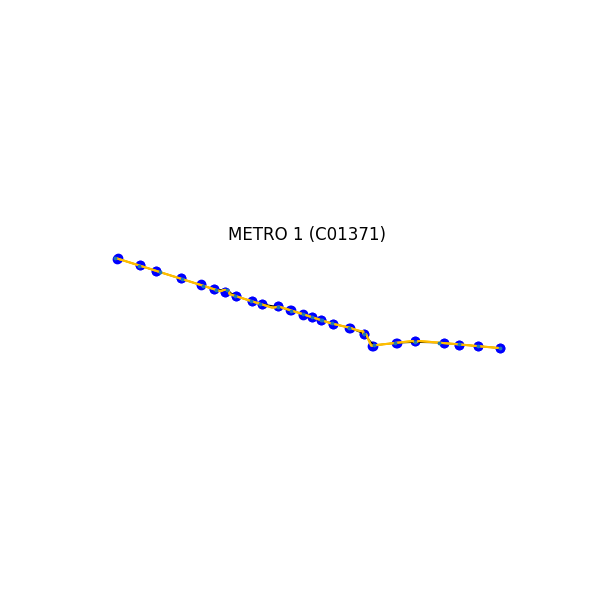

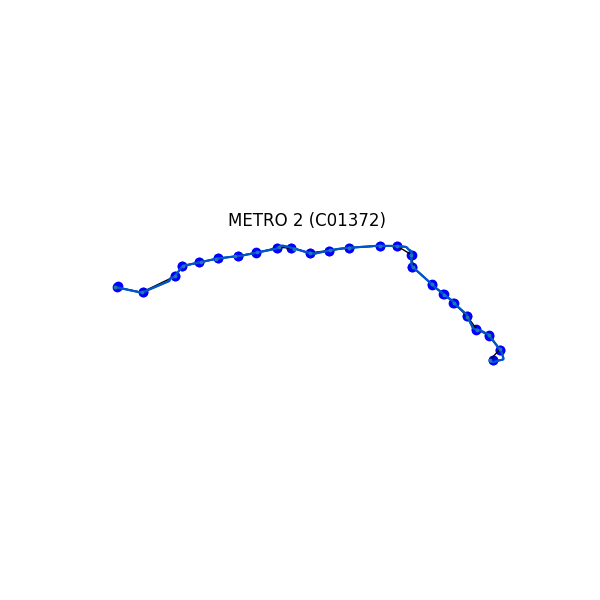

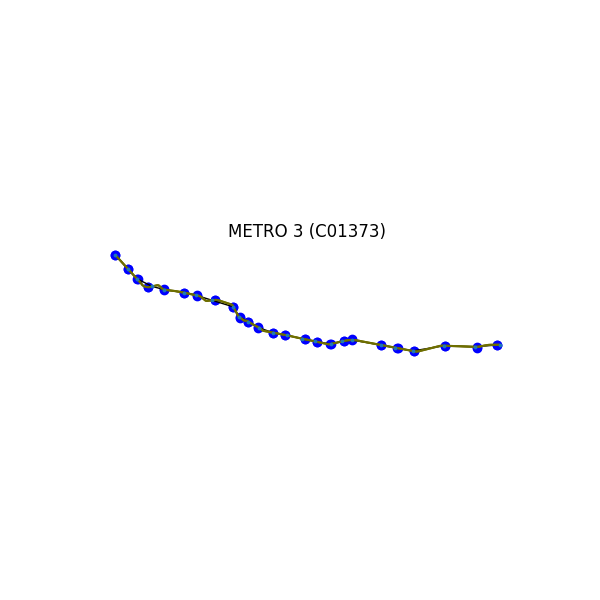

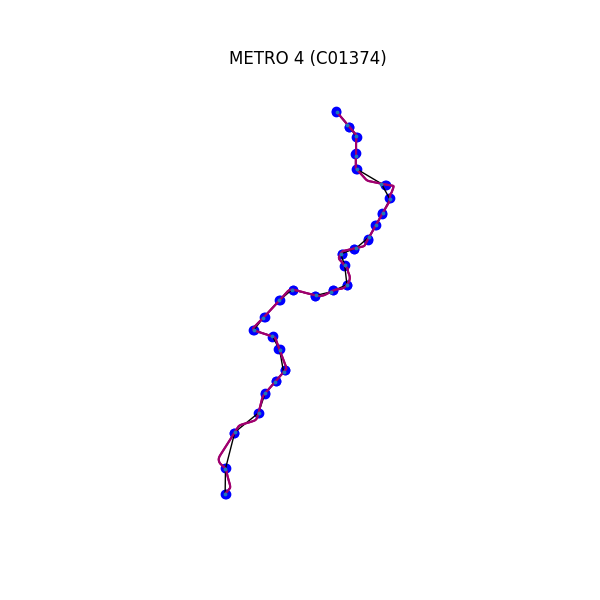

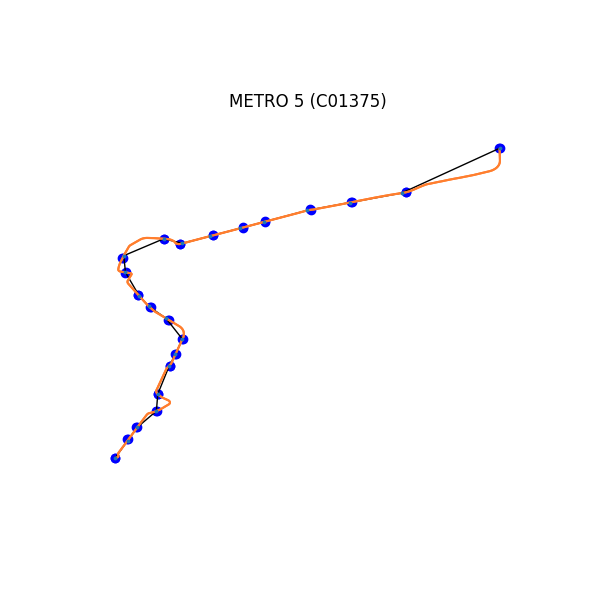

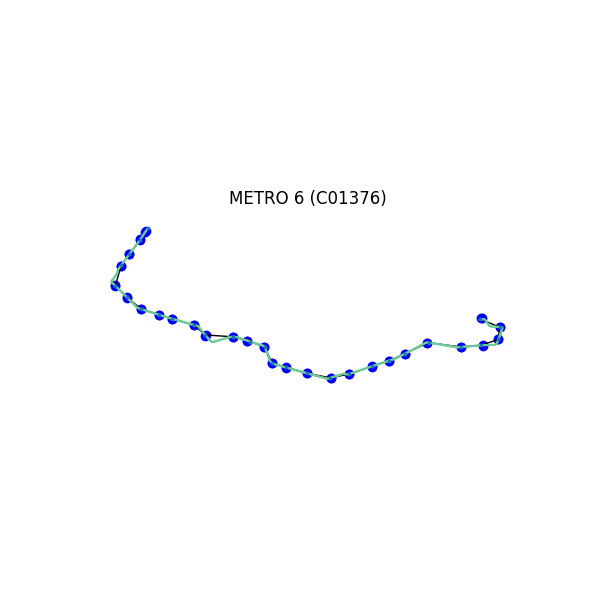

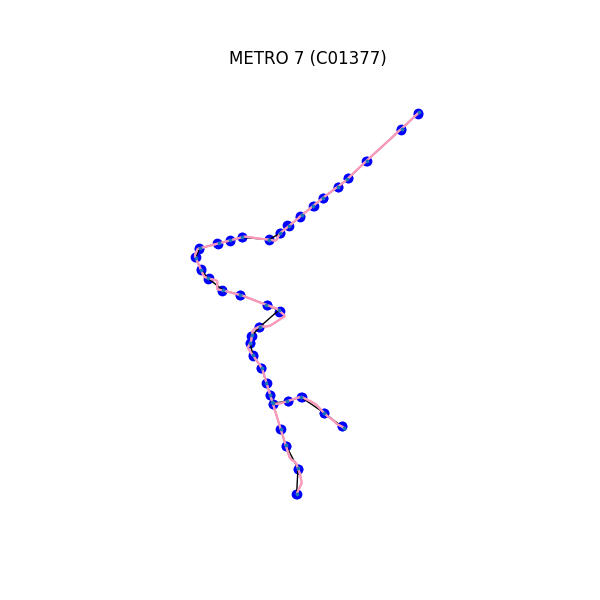

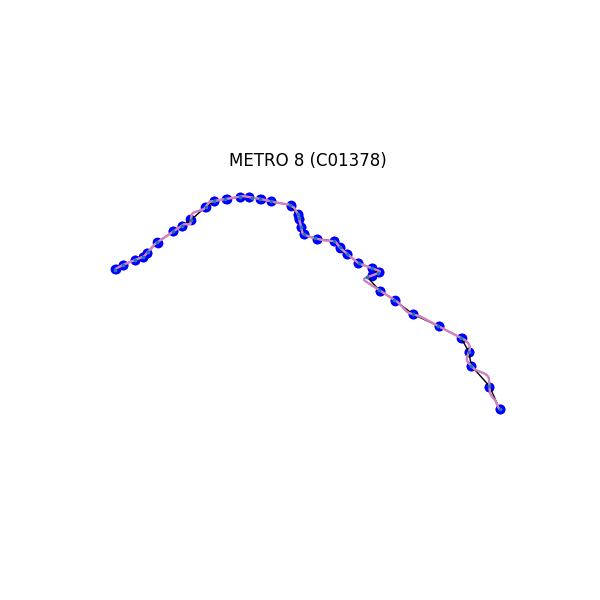

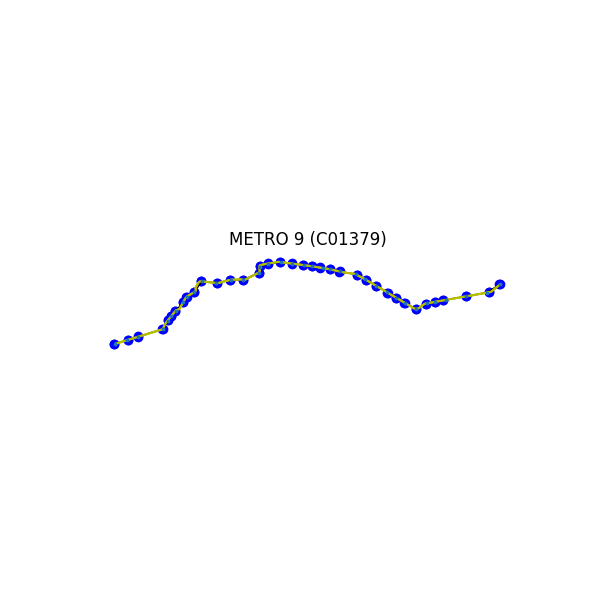

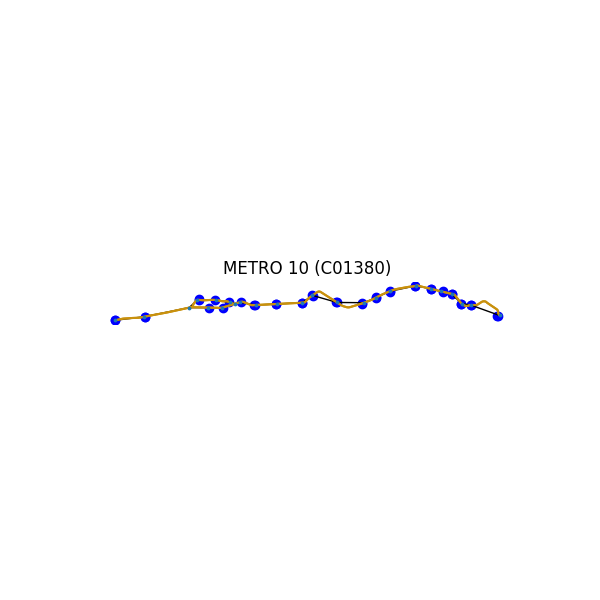

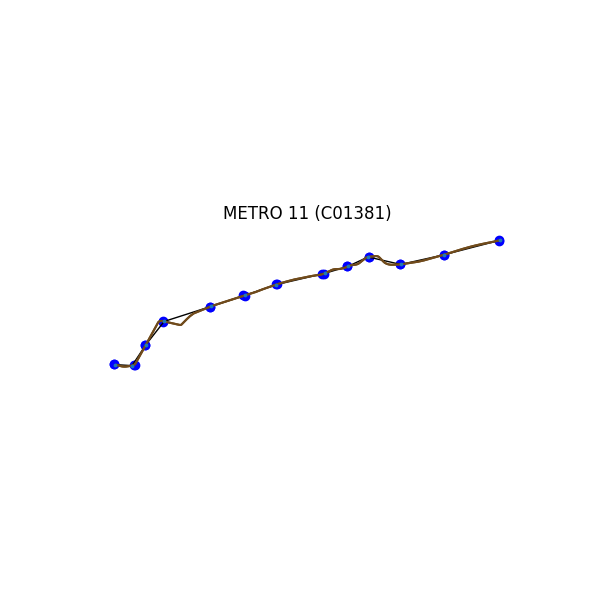

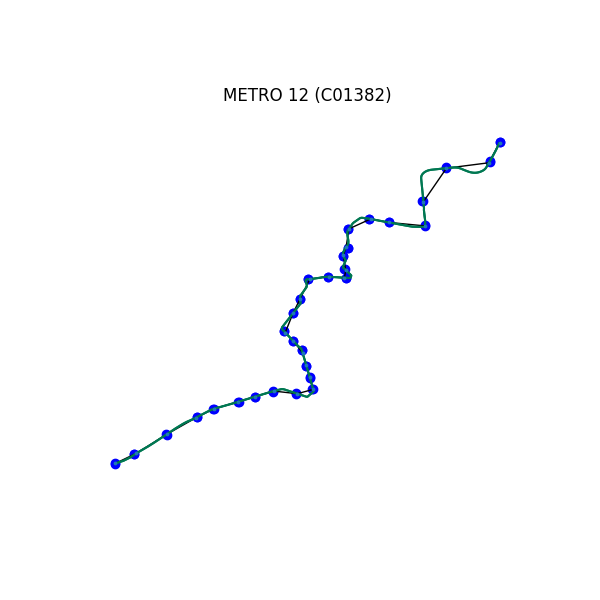

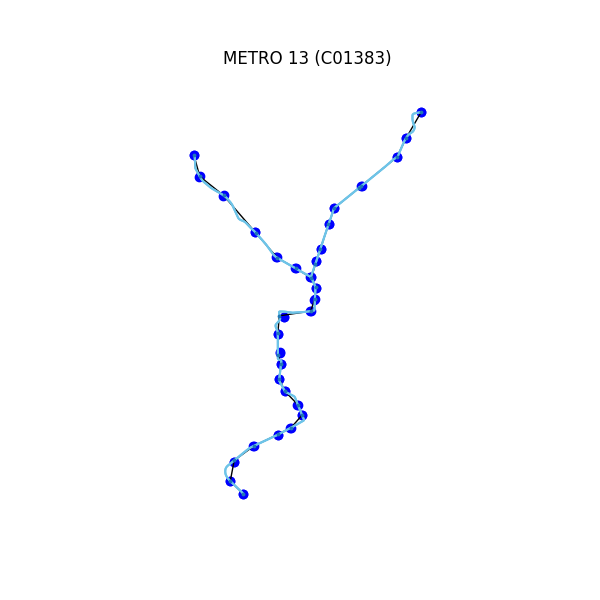

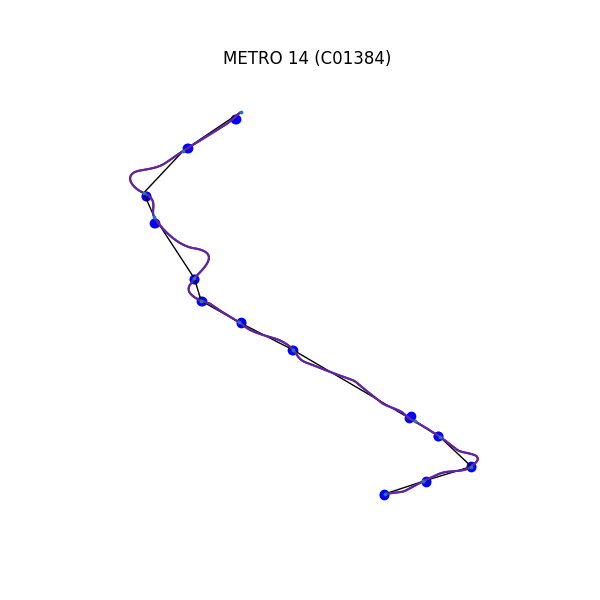

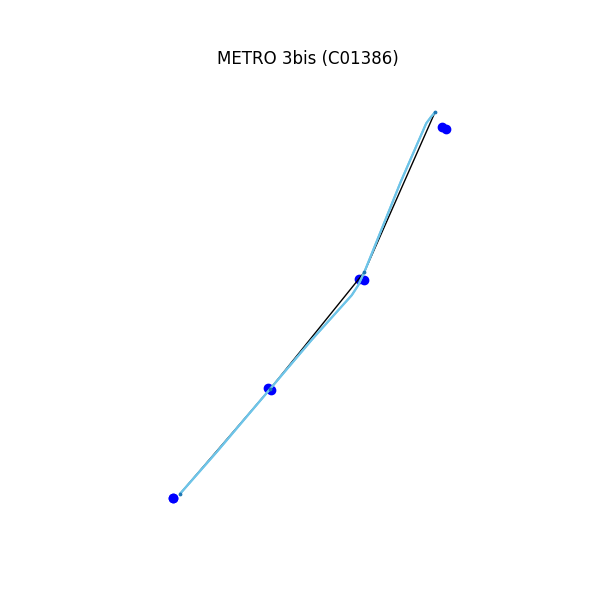

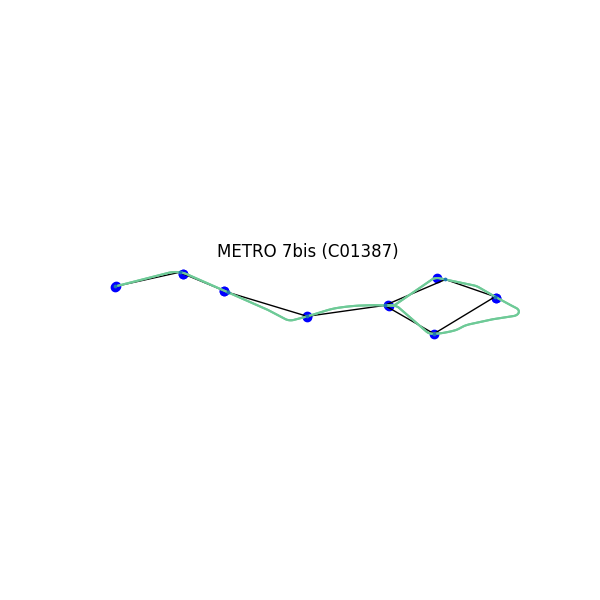

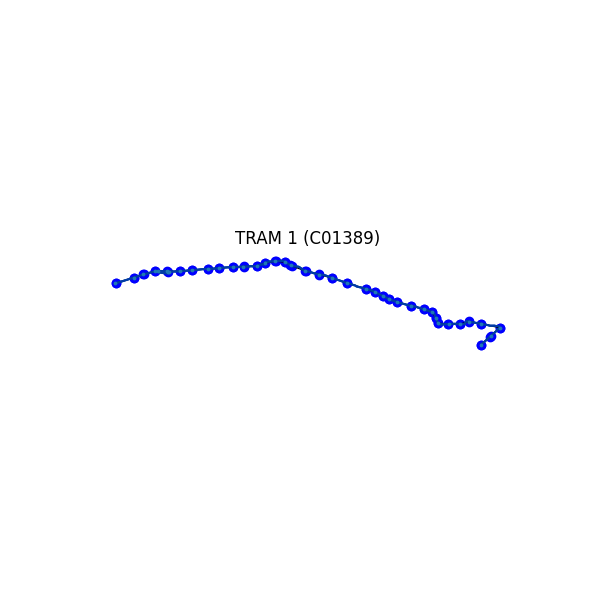

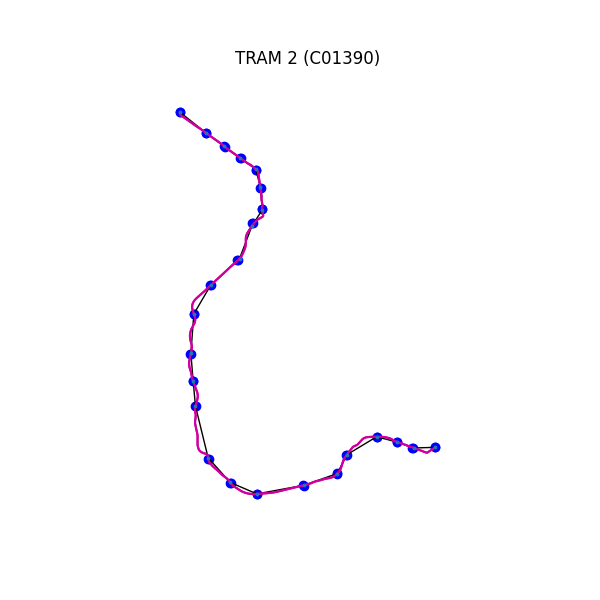

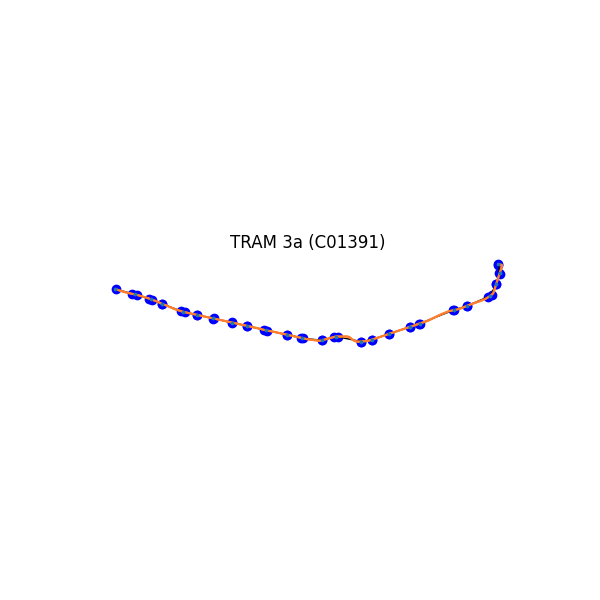

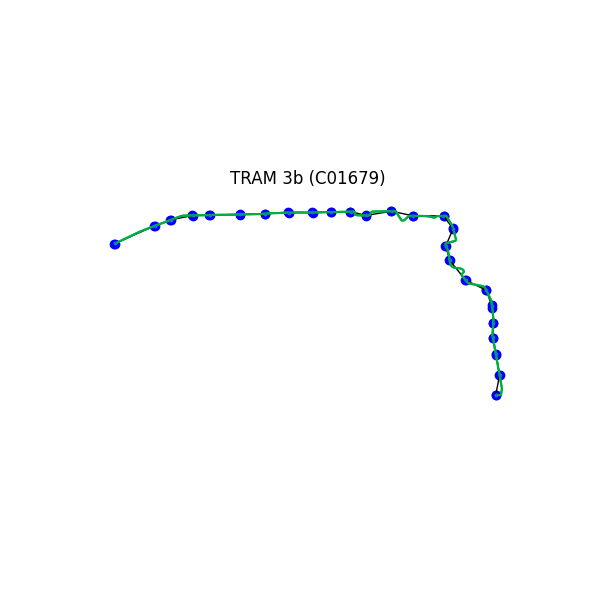

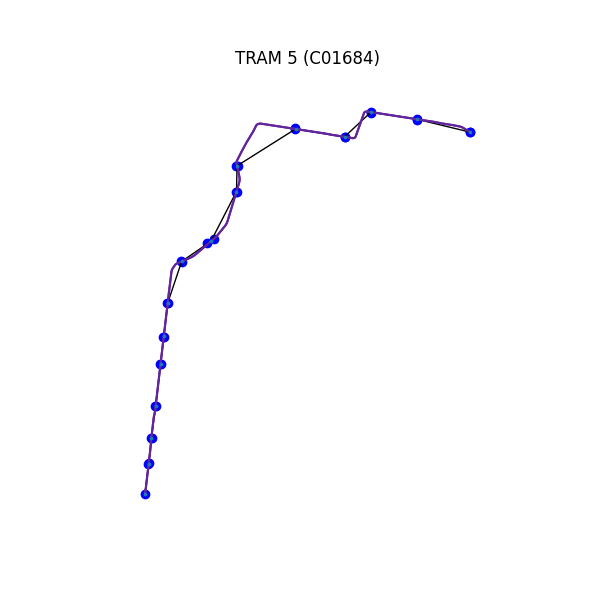

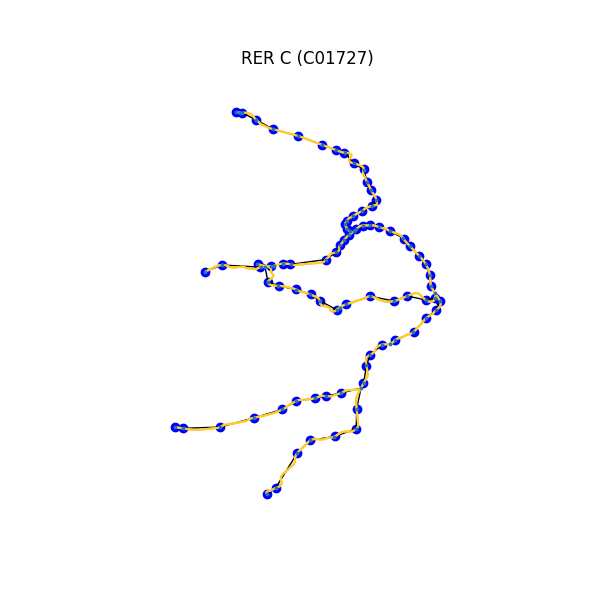

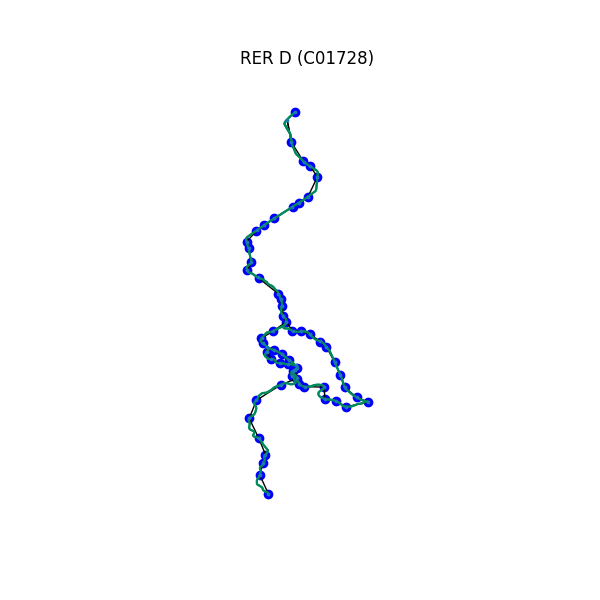

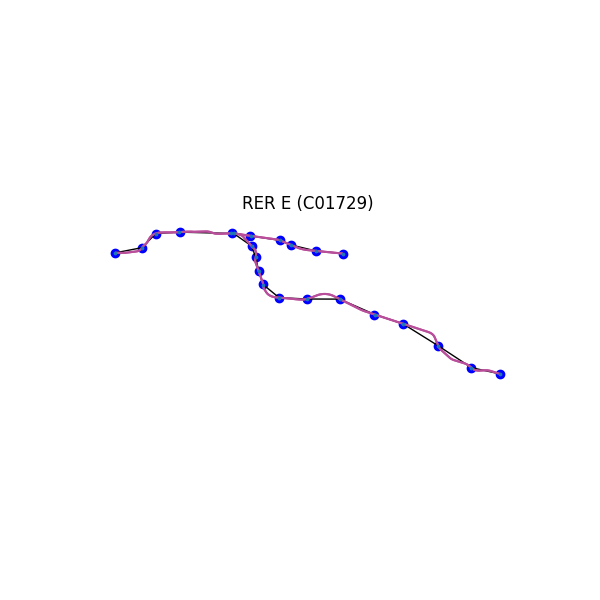

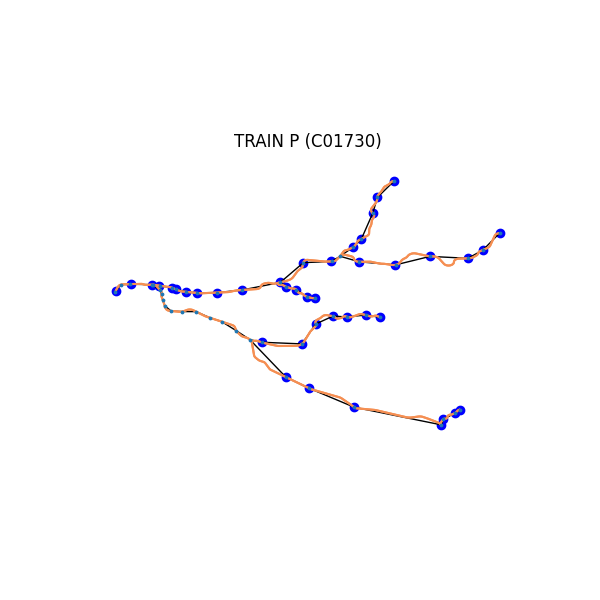

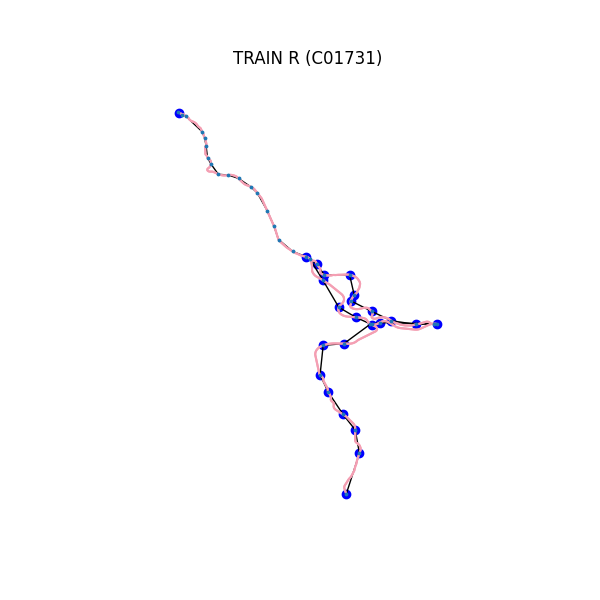

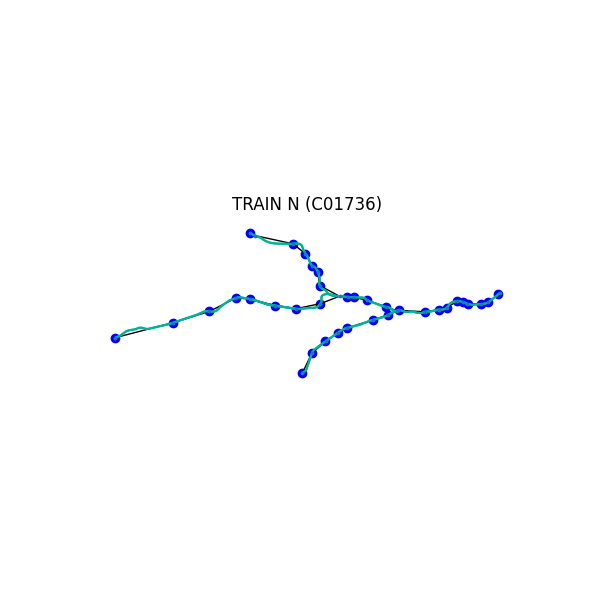

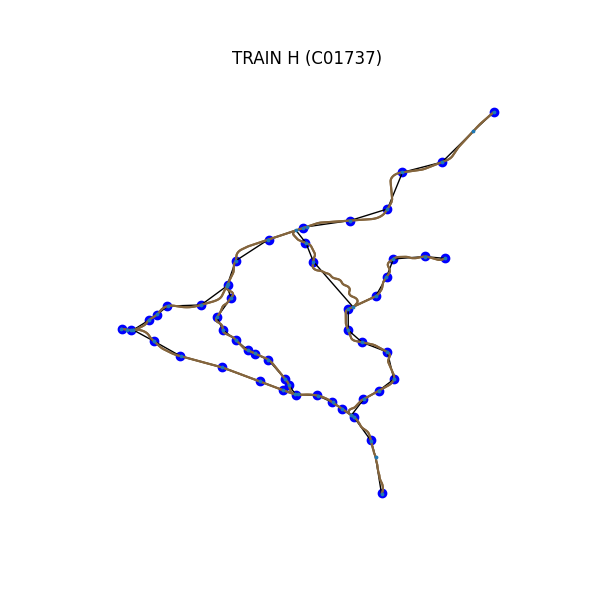

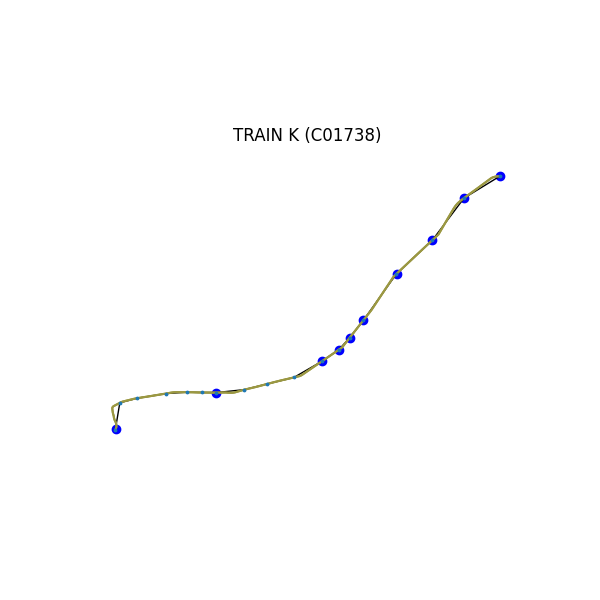

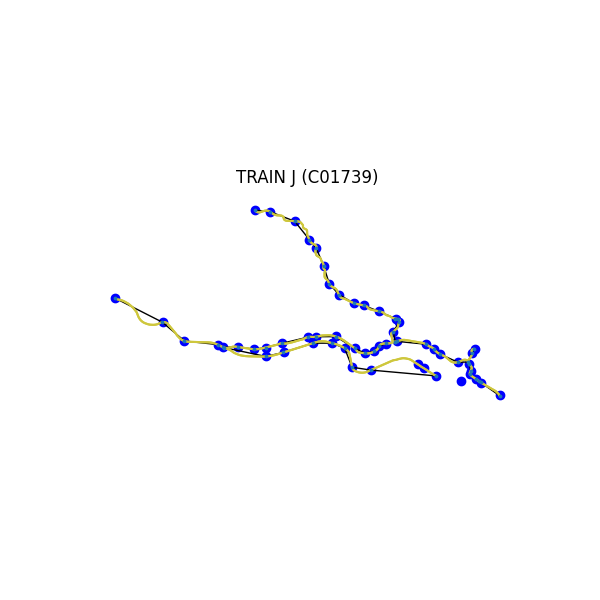

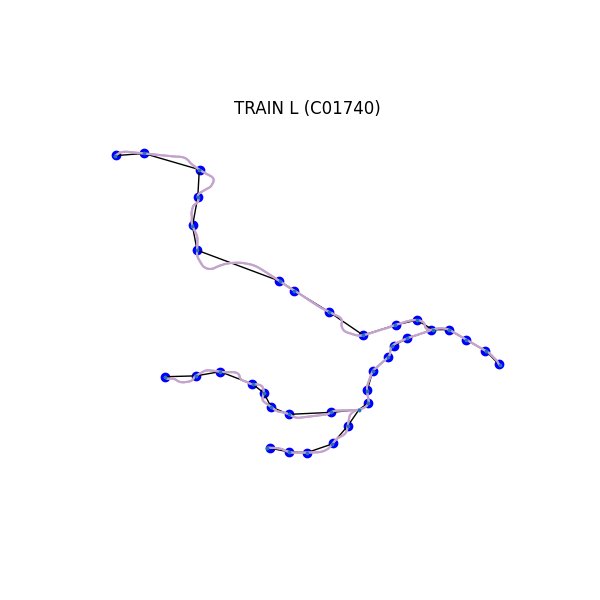

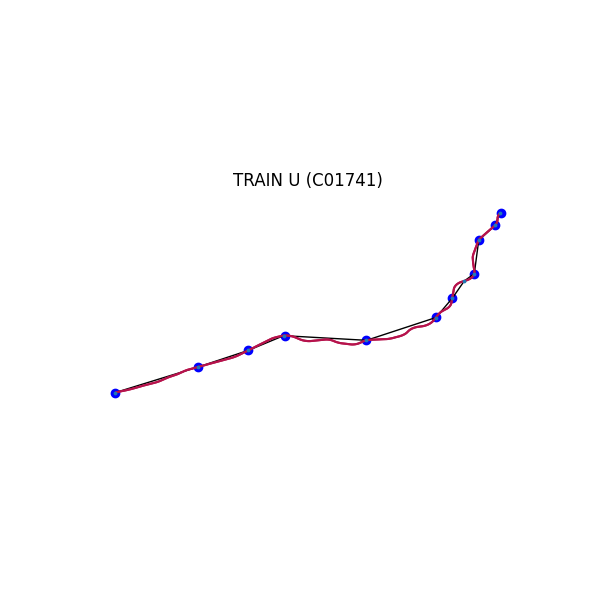

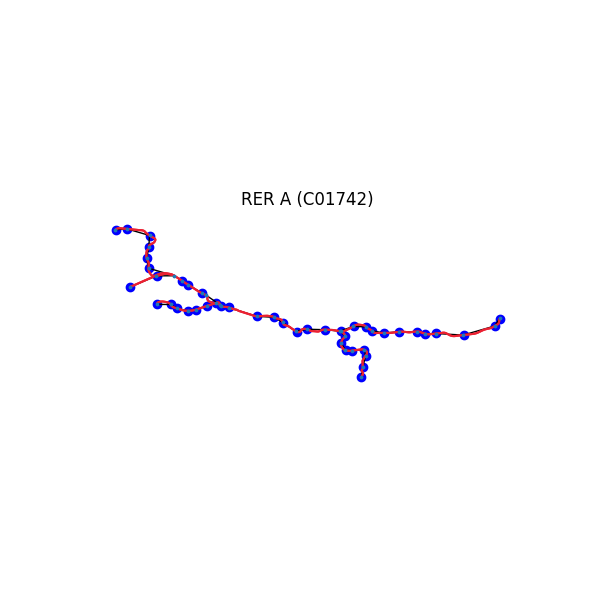

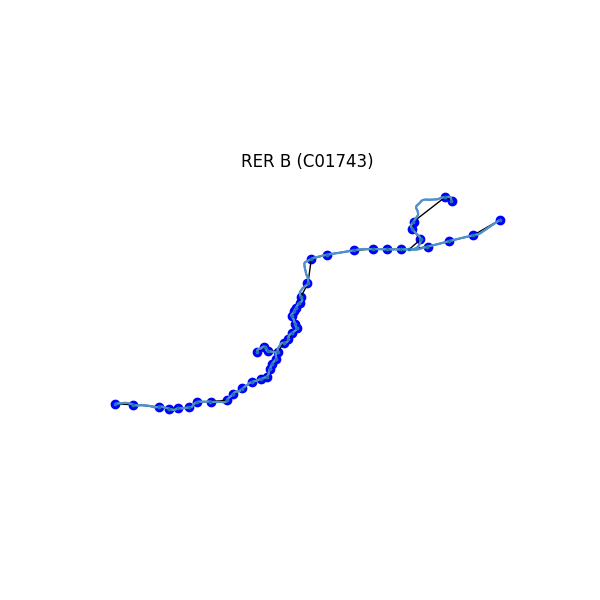

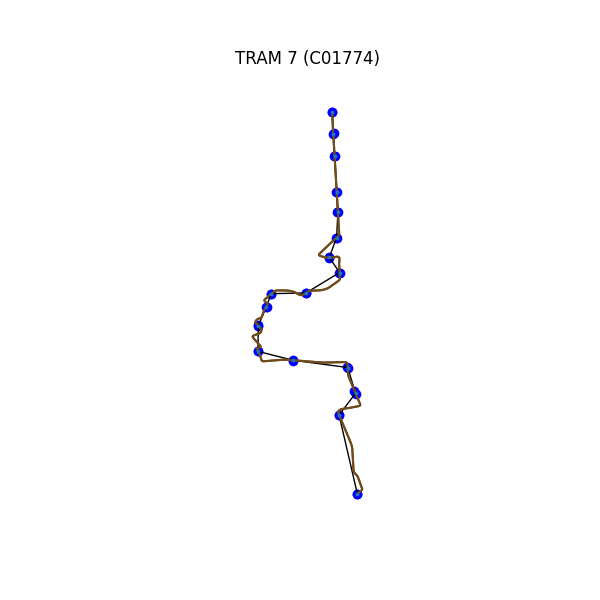

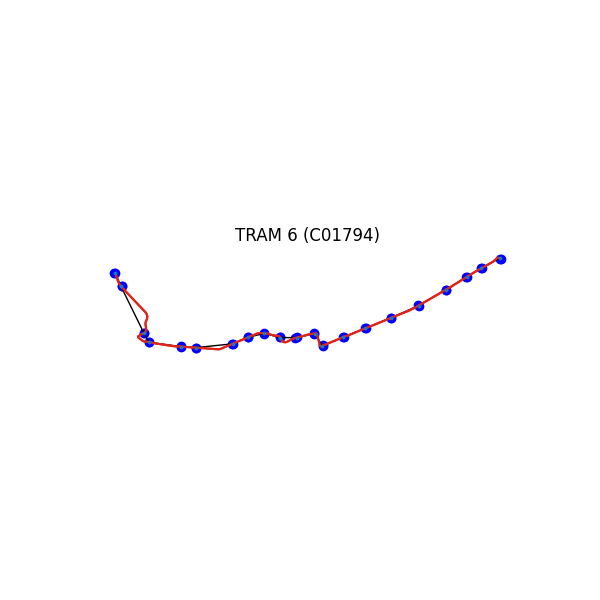

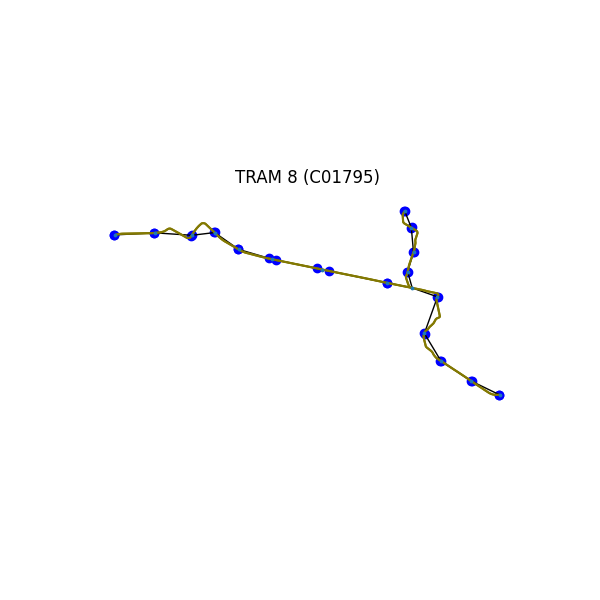

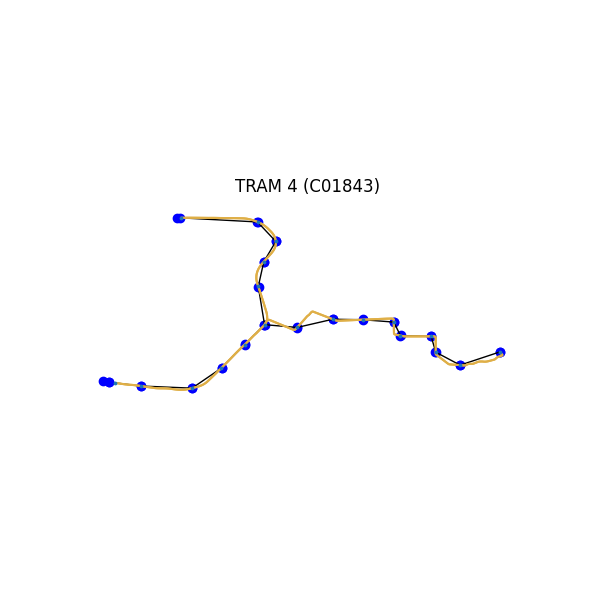

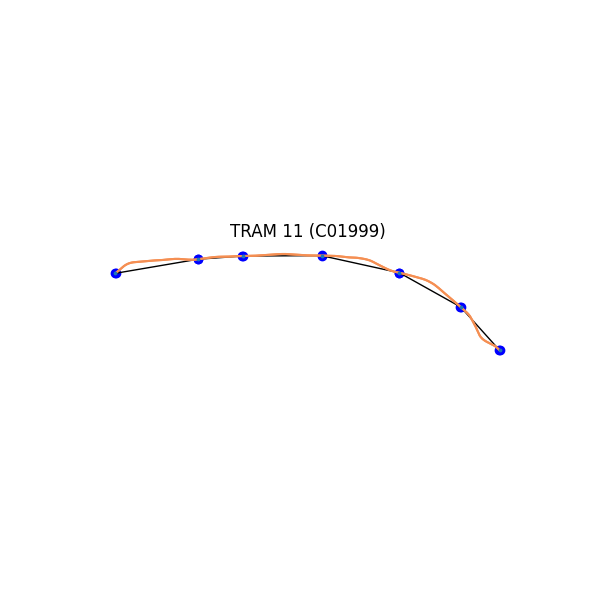

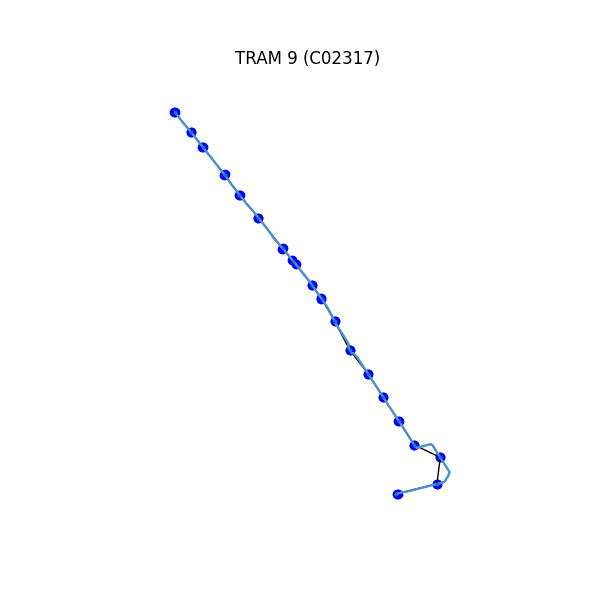

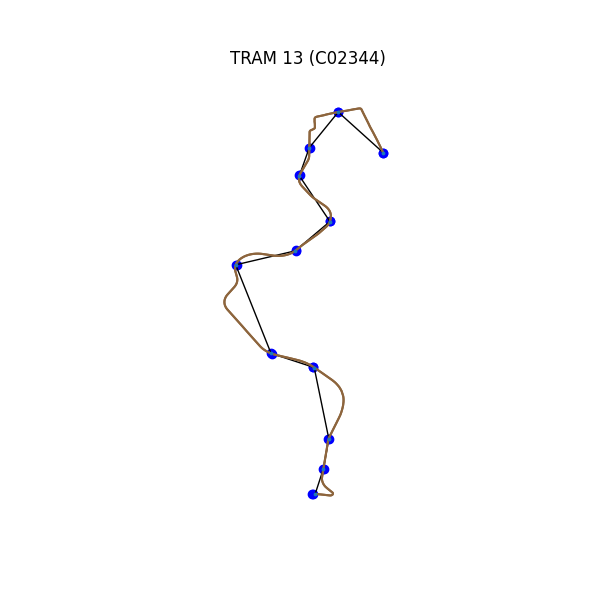

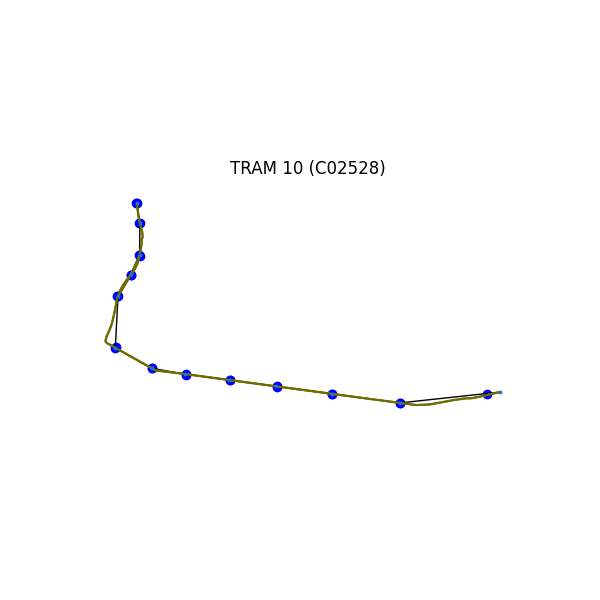

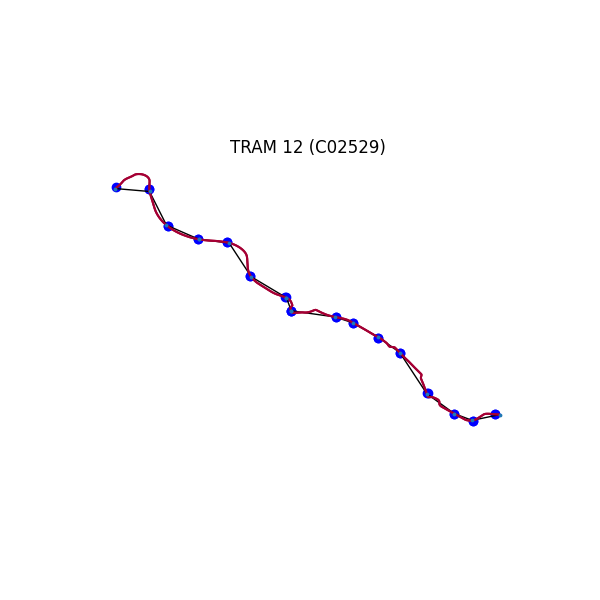

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget

for line_id in lines:
    line = lines[line_id]
    G = line['graph']
    network_line = network[network['short_id'] == line_id]

    f, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    title = f"{network_line['name'].iloc[0]} ({line_id})"
    ax.set_title(title)

    # Plot line
    network_line.plot(color="#"+network_line.color.iloc[0], ax=ax)

    # Plot stops
    stops[stops['line_short_id'] == line_id].plot(color="blue", ax=ax)
    
    # Plot graph nodes
    node_positions = nx.get_node_attributes(G, "position")
    nx.draw(G, pos=node_positions, ax=ax, node_size=3)
    
    plt.show()

In [25]:
# Compute shortest paths on line graph
for line_id in lines:
    line = lines[line_id]
    G = line['graph']

    shortest_paths = nx.shortest_path(G)
    lines[line_id]['shortest_paths'] = shortest_paths

# Print an example
lines[line_id]['shortest_paths']

{0: {0: [0],
  1: [0, 1],
  6: [0, 6],
  14: [0, 1, 14],
  9: [0, 6, 9],
  15: [0, 1, 14, 15],
  3: [0, 6, 9, 3],
  18: [0, 1, 14, 15, 18],
  2: [0, 6, 9, 3, 2],
  12: [0, 1, 14, 15, 18, 12],
  8: [0, 6, 9, 3, 2, 8],
  10: [0, 1, 14, 15, 18, 12, 10],
  17: [0, 6, 9, 3, 2, 8, 17],
  11: [0, 1, 14, 15, 18, 12, 10, 11],
  13: [0, 1, 14, 15, 18, 12, 10, 11, 13],
  4: [0, 1, 14, 15, 18, 12, 10, 11, 13, 4],
  5: [0, 1, 14, 15, 18, 12, 10, 11, 13, 4, 5],
  7: [0, 1, 14, 15, 18, 12, 10, 11, 13, 4, 5, 7],
  16: [0, 1, 14, 15, 18, 12, 10, 11, 13, 4, 5, 7, 16]},
 1: {1: [1],
  0: [1, 0],
  14: [1, 14],
  6: [1, 0, 6],
  15: [1, 14, 15],
  9: [1, 0, 6, 9],
  18: [1, 14, 15, 18],
  3: [1, 0, 6, 9, 3],
  12: [1, 14, 15, 18, 12],
  2: [1, 0, 6, 9, 3, 2],
  10: [1, 14, 15, 18, 12, 10],
  8: [1, 0, 6, 9, 3, 2, 8],
  11: [1, 14, 15, 18, 12, 10, 11],
  17: [1, 0, 6, 9, 3, 2, 8, 17],
  13: [1, 14, 15, 18, 12, 10, 11, 13],
  4: [1, 14, 15, 18, 12, 10, 11, 13, 4],
  5: [1, 14, 15, 18, 12, 10, 11, 13, 4, 5],

## Compute shortest path for each pair of stops on each line

### Enrich network data

In [26]:
# Compute line network with reverse segments.
reversed_network = network.copy()
reversed_network.geometry = reversed_network.geometry.reverse()
network = pd.concat([network, reversed_network])

# Compute positions of (start, end) for each line segment
network['start_pos'] = network.geometry.apply(lambda seg: Point(seg.coords[0]))
network['end_pos'] = network.geometry.apply(lambda seg: Point(seg.coords[-1]))
network

,short_id,geometry,name,company,transportation_type,color,in_idf,picture_url,start_pos,end_pos
0,C01743,"LINESTRING (2.21226 48.70597, 2.21246 48.70594...",RER B,RATP,RER,5091cb,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.21226 48.70597),POINT (2.23731 48.70814)
2,C01731,"LINESTRING (2.69248 48.33268, 2.69139 48.33228...",TRAIN R,SNCF,TRAIN,f49fb3,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.69248 48.33268),POINT (2.68565 48.26776)
3,C01728,"LINESTRING (2.46155 48.59281, 2.46129 48.59300...",RER D,SNCF,RER,008b5b,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.46155 48.59281),POINT (2.46246 48.60556)
4,C01730,"LINESTRING (3.01201 48.56195, 3.01158 48.56227...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (3.01201 48.56195),POINT (2.88825 48.61402)
5,C01730,"LINESTRING (3.07563 49.13547, 3.07596 49.13832...",TRAIN P,SNCF,TRAIN,f58f53,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (3.07563 49.13547),POINT (3.12069 49.17962)
...,...,...,...,...,...,...,...,...,...,...
1300,C02528,"LINESTRING (2.28070 48.76272, 2.28070 48.76272)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.28070 48.76272),POINT (2.28070 48.76272)
1301,C02528,"LINESTRING (2.25189 48.77984, 2.25003 48.77669)",TRAM 10,RD Bièvre,TRAMWAY,6e6e00,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.25189 48.77984),POINT (2.25003 48.77669)
295,C02529,"LINESTRING (2.29456 48.70224, 2.29456 48.70224)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.29456 48.70224),POINT (2.29456 48.70224)
296,C02529,"LINESTRING (2.33325 48.67638, 2.33325 48.67638)",TRAM 12,SNCF,TRAMWAY,a50034,True,https://data.iledefrance-mobilites.fr/explore/...,POINT (2.33325 48.67638),POINT (2.33325 48.67638)


In [27]:
# Compute node dataframe
nodes = []
for k,v in lines.items():
    df = v['nodes']
    df['line_short_id'] = k
    nodes.append(df)
nodes = pd.concat(nodes).reset_index()
nodes

,index,nodeID,geometry,line_short_id
0,0,0,POINT (2.44044 48.84446),C01371
1,1,1,POINT (2.42921 48.84547),C01371
2,2,2,POINT (2.33650 48.86235),C01371
3,3,3,POINT (2.33013 48.86434),C01371
4,4,4,POINT (2.32294 48.86629),C01371
...,...,...,...,...
1273,14,14,POINT (2.33325 48.67638),C02529
1274,15,15,POINT (2.33536 48.67064),C02529
1275,16,16,POINT (2.42759 48.62468),C02529
1276,17,17,POINT (2.25752 48.72473),C02529


### Create stops pairs

In [28]:
# Create each pair of stops
stops_pairs = []
for line_id in lines:
    line_stops = stops[stops['line_short_id'] == line_id]
    shortest_paths = lines[line_id]['shortest_paths']

    line_stops_pairs = line_stops.assign(dummy=1).merge(line_stops.assign(
        dummy=1), on='dummy', how='outer', suffixes=('_start', '_end'))
    line_stops_pairs = line_stops_pairs.drop('dummy', axis=1)

    # Exclude pairs with identical nodes on graph
    line_stops_pairs = line_stops_pairs[line_stops_pairs.nearest_node_id_start !=
                                        line_stops_pairs.nearest_node_id_end]

    # Compute shortest path for each pair
    line_stops_pairs['shortest_path_nodes'] = line_stops_pairs.apply(
            lambda row: shortest_paths[row.nearest_node_id_start][row.nearest_node_id_end], axis=1)
    stops_pairs.append(line_stops_pairs)

stops_pairs = pd.concat(stops_pairs)
stops_pairs

,id_start,longitude_start,latitude_start,name_start,line_id_start,company_start,line_short_id_start,short_id_start,geometry_start,nearest_node_id_start,...,longitude_end,latitude_end,name_end,line_id_end,company_end,line_short_id_end,short_id_end,geometry_end,nearest_node_id_end,shortest_path_nodes
1,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1,...,2.410805,48.847008,Porte de Vincennes,IDFM:C01371,RATP,C01371,463012,POINT (2.41080 48.84701),24,"[1, 8, 24]"
2,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1,...,2.336562,48.862367,Palais Royal - Musée du Louvre,IDFM:C01371,RATP,C01371,463227,POINT (2.33656 48.86237),2,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]"
3,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1,...,2.329745,48.864550,Tuileries,IDFM:C01371,RATP,C01371,22075,POINT (2.32975 48.86455),3,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2..."
4,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1,...,2.300760,48.872038,George V,IDFM:C01371,RATP,C01371,463185,POINT (2.30076 48.87204),21,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2..."
5,IDFM:463130,2.429228,48.845492,Bérault,IDFM:C01371,RATP,C01371,463130,POINT (2.42923 48.84549),1,...,2.295117,48.873929,Charles de Gaulle - Etoile,IDFM:C01371,RATP,C01371,22086,POINT (2.29512 48.87393),11,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,IDFM:486978,2.355340,48.667798,Parc du Château,IDFM:C02529,SNCF,C02529,486978,POINT (2.35534 48.66780),12,...,2.373808,48.658740,Amédée Gordini,IDFM:C02529,SNCF,C02529,486975,POINT (2.37381 48.65874),11,"[12, 10, 11]"
1019,IDFM:486978,2.355340,48.667798,Parc du Château,IDFM:C02529,SNCF,C02529,486978,POINT (2.35534 48.66780),12,...,2.362703,48.665328,Coteaux de l'Orge,IDFM:C02529,SNCF,C02529,486991,POINT (2.36270 48.66533),10,"[12, 10]"
1020,IDFM:486978,2.355340,48.667798,Parc du Château,IDFM:C02529,SNCF,C02529,486978,POINT (2.35534 48.66780),12,...,2.335124,48.670593,Épinay-sur-Orge,IDFM:C02529,SNCF,C02529,486899,POINT (2.33512 48.67059),18,"[12, 18]"
1021,IDFM:486978,2.355340,48.667798,Parc du Château,IDFM:C02529,SNCF,C02529,486978,POINT (2.35534 48.66780),12,...,2.306909,48.700871,Chilly-Mazarin,IDFM:C02529,SNCF,C02529,486894,POINT (2.30691 48.70087),6,"[12, 18, 15, 14, 1, 0, 6]"


In [29]:
# Get relevant keys for stops_pairs DataFrame

STOP_PAIRS_KEYS = {
    'id_start': 'stop_id_start',
    # 'short_id_start': 'stop_short_id_start',
    'geometry_start': 'stop_pos_start',
    'name_start': 'stop_name_start',

    'id_end': 'stop_id_end',
    # 'short_id_end': 'stop_short_id_end',
    'geometry_end': 'stop_pos_end',
    'name_end': 'stop_name_end',

    'line_short_id_start': 'line_short_id',
    'shortest_path_nodes': 'shortest_path_nodes',
}

stops_pairs = stops_pairs[list(STOP_PAIRS_KEYS.keys())].rename(STOP_PAIRS_KEYS, axis='columns')
display(stops_pairs.iloc[0])

stop_id_start                                            IDFM:463130
stop_pos_start         POINT (2.4292278831660283 48.845491696267075)
stop_name_start                                              Bérault
stop_id_end                                              IDFM:463012
stop_pos_end            POINT (2.4108049967015006 48.84700773108863)
stop_name_end                                     Porte de Vincennes
line_short_id                                                 C01371
shortest_path_nodes                                       [1, 8, 24]
Name: 1, dtype: object

### Create segments (parts of a shortest path of stops pairs)

In [30]:
# Decompose each shortest path as pairs of nodes
stops_pairs['shortest_path_segment'] = stops_pairs['shortest_path_nodes'].apply(lambda x: list(zip(x[:-1], x[1:])))
stops_pairs.head()

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,shortest_path_segment
1,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,"[1, 8, 24]","[(1, 8), (8, 24)]"
2,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]","[(1, 8), (8, 24), (24, 25), (25, 6), (6, 7), (..."
3,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22075,POINT (2.32975 48.86455),Tuileries,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...","[(1, 8), (8, 24), (24, 25), (25, 6), (6, 7), (..."
4,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463185,POINT (2.30076 48.87204),George V,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...","[(1, 8), (8, 24), (24, 25), (25, 6), (6, 7), (..."
5,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22086,POINT (2.29512 48.87393),Charles de Gaulle - Etoile,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...","[(1, 8), (8, 24), (24, 25), (25, 6), (6, 7), (..."


### Get information about segments of each shortest path

In [31]:
# Flatten pairs of nodes for each shortest path
segments = stops_pairs.explode('shortest_path_segment').reset_index()
segments = segments.drop(['index'], axis=1)
segments['start_node'] = segments['shortest_path_segment'].apply(lambda x: x[0])
segments['end_node'] = segments['shortest_path_segment'].apply(lambda x: x[1])
segments = segments.drop(['shortest_path_segment'], axis=1)
segments.head()

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node
0,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,"[1, 8, 24]",1,8
1,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,"[1, 8, 24]",8,24
2,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]",1,8
3,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]",8,24
4,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]",24,25


In [32]:
# Shortest path segment example
segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node
229143,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",33,23
229144,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",23,24
229145,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",24,32
229146,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",32,19
229147,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",19,10
229148,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",10,11
229149,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",11,36
229150,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",36,20
229151,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",20,21
229152,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",21,29


In [33]:
# Get node positions
segments = segments.merge(nodes,
                          left_on=['start_node', 'line_short_id'],
                          right_on=['nodeID', 'line_short_id'],
                          how='inner', suffixes=('_segment', '_start_node'))
segments['start_pos'] = segments.geometry
segments = segments.drop(['geometry', 'nodeID'], axis=1)
segments = segments.merge(nodes,
                          left_on=['end_node', 'line_short_id'],
                          right_on=['nodeID', 'line_short_id'],
                          how='inner', suffixes=('_segment', '_end_node'))
segments['end_pos'] = segments.geometry
segments = segments.drop(['geometry', 'nodeID'], axis=1)                 

segments = segments.drop(['index_end_node', 'index_segment'], axis=1)

segments.head()

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos
0,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,"[1, 8, 24]",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642)
1,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642)
2,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22075,POINT (2.32975 48.86455),Tuileries,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642)
3,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463185,POINT (2.30076 48.87204),George V,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642)
4,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22086,POINT (2.29512 48.87393),Charles de Gaulle - Etoile,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642)


In [34]:
# Shortest path segments example
sp_ex1 = segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]
display(sp_ex1.shape)
sp_ex1

(28, 12)

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos
220531,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",12,13,POINT (2.32627 48.86963),POINT (2.32208 48.86682)
222771,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",28,12,POINT (2.33119 48.87048),POINT (2.32627 48.86963)
225119,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",27,28,POINT (2.33846 48.87169),POINT (2.33119 48.87048)
227579,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",26,27,POINT (2.34456 48.87126),POINT (2.33846 48.87169)
230191,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",37,26,POINT (2.34849 48.87059),POINT (2.34456 48.87126)
232891,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",15,37,POINT (2.35382 48.86940),POINT (2.34849 48.87059)
235663,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",14,15,POINT (2.36276 48.86760),POINT (2.35382 48.86940)
238457,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",35,14,POINT (2.36666 48.86326),POINT (2.36276 48.86760)
241323,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",5,35,POINT (2.36721 48.86117),POINT (2.36666 48.86326)
244213,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",4,5,POINT (2.36818 48.85710),POINT (2.36721 48.86117)


In [35]:
# Get LineString for each segment
segments = segments.merge(network.add_prefix('line_'),
                          left_on=['start_pos', 'end_pos', 'line_short_id'],
                          right_on=['line_start_pos', 'line_end_pos', 'line_short_id'],
                          how='inner')
segments = segments.drop(['line_company', 'line_color',
                         'line_in_idf', 'line_picture_url', 'line_start_pos', 'line_end_pos'], axis=1)
segments.head()

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos,line_geometry,line_name,line_transportation_type
0,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,"[1, 8, 24]",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642),"LINESTRING (2.42921 48.84547, 2.42462 48.84589...",METRO 1,METRO
1,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2]",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642),"LINESTRING (2.42921 48.84547, 2.42462 48.84589...",METRO 1,METRO
2,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22075,POINT (2.32975 48.86455),Tuileries,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642),"LINESTRING (2.42921 48.84547, 2.42462 48.84589...",METRO 1,METRO
3,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463185,POINT (2.30076 48.87204),George V,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642),"LINESTRING (2.42921 48.84547, 2.42462 48.84589...",METRO 1,METRO
4,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22086,POINT (2.29512 48.87393),Charles de Gaulle - Etoile,C01371,"[1, 8, 24, 25, 6, 7, 14, 17, 15, 16, 23, 22, 2...",1,8,POINT (2.42921 48.84547),POINT (2.41876 48.84642),"LINESTRING (2.42921 48.84547, 2.42462 48.84589...",METRO 1,METRO


In [36]:
# Shortest path segments example
sp_ex2 = segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]
display(sp_ex2.shape)
sp_ex2

(28, 15)

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,shortest_path_nodes,start_node,end_node,start_pos,end_pos,line_geometry,line_name,line_transportation_type
220531,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",12,13,POINT (2.32627 48.86963),POINT (2.32208 48.86682),"LINESTRING (2.32627 48.86963, 2.32550 48.86950...",METRO 8,METRO
222771,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",28,12,POINT (2.33119 48.87048),POINT (2.32627 48.86963),"LINESTRING (2.33119 48.87048, 2.32792 48.86992...",METRO 8,METRO
225119,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",27,28,POINT (2.33846 48.87169),POINT (2.33119 48.87048),"LINESTRING (2.33846 48.87169, 2.33257 48.87071...",METRO 8,METRO
227579,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",26,27,POINT (2.34456 48.87126),POINT (2.33846 48.87169),"LINESTRING (2.34456 48.87126, 2.34092 48.87187...",METRO 8,METRO
230191,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",37,26,POINT (2.34849 48.87059),POINT (2.34456 48.87126),"LINESTRING (2.34849 48.87059, 2.34798 48.87070...",METRO 8,METRO
232891,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",15,37,POINT (2.35382 48.86940),POINT (2.34849 48.87059),"LINESTRING (2.35382 48.86940, 2.35358 48.86945...",METRO 8,METRO
235663,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",14,15,POINT (2.36276 48.86760),POINT (2.35382 48.86940),"LINESTRING (2.36276 48.86760, 2.36237 48.86780...",METRO 8,METRO
238457,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",35,14,POINT (2.36666 48.86326),POINT (2.36276 48.86760),"LINESTRING (2.36666 48.86326, 2.36619 48.86405...",METRO 8,METRO
241323,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",5,35,POINT (2.36721 48.86117),POINT (2.36666 48.86326),"LINESTRING (2.36721 48.86117, 2.36686 48.86268...",METRO 8,METRO
244213,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,"[33, 23, 24, 32, 19, 10, 11, 36, 20, 21, 29, 3...",4,5,POINT (2.36818 48.85710),POINT (2.36721 48.86117),"LINESTRING (2.36818 48.85710, 2.36741 48.86033...",METRO 8,METRO


In [37]:
SEGMENTS_KEYS_TO_KEEP = ['stop_id_start',
                         'stop_pos_start',
                         'stop_name_start',
                         'stop_id_end',
                         'stop_pos_end',
                         'stop_name_end',
                         'line_short_id',
                         'line_name',
                         'line_transportation_type',
                         'line_geometry',
                         ]
segments = segments[SEGMENTS_KEYS_TO_KEEP]
segments

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
0,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463012,POINT (2.41080 48.84701),Porte de Vincennes,C01371,METRO 1,METRO,"LINESTRING (2.42921 48.84547, 2.42462 48.84589..."
1,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463227,POINT (2.33656 48.86237),Palais Royal - Musée du Louvre,C01371,METRO 1,METRO,"LINESTRING (2.42921 48.84547, 2.42462 48.84589..."
2,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22075,POINT (2.32975 48.86455),Tuileries,C01371,METRO 1,METRO,"LINESTRING (2.42921 48.84547, 2.42462 48.84589..."
3,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:463185,POINT (2.30076 48.87204),George V,C01371,METRO 1,METRO,"LINESTRING (2.42921 48.84547, 2.42462 48.84589..."
4,IDFM:463130,POINT (2.42923 48.84549),Bérault,IDFM:22086,POINT (2.29512 48.87393),Charles de Gaulle - Etoile,C01371,METRO 1,METRO,"LINESTRING (2.42921 48.84547, 2.42462 48.84589..."
...,...,...,...,...,...,...,...,...,...,...
991875,IDFM:486894,POINT (2.30691 48.70087),Chilly-Mazarin,IDFM:486900,POINT (2.42546 48.62491),Évry - Courcouronnes,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.41545 48.62213, 2.41564 48.62216..."
991876,IDFM:486957,POINT (2.28080 48.70803),Champlan,IDFM:486902,POINT (2.42549 48.62495),Évry - Courcouronnes,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.41545 48.62213, 2.41564 48.62216..."
991877,IDFM:486957,POINT (2.28080 48.70803),Champlan,IDFM:486900,POINT (2.42546 48.62491),Évry - Courcouronnes,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.41545 48.62213, 2.41564 48.62216..."
991878,IDFM:486978,POINT (2.35534 48.66780),Parc du Château,IDFM:486902,POINT (2.42549 48.62495),Évry - Courcouronnes,C02529,TRAM 12,TRAMWAY,"LINESTRING (2.41545 48.62213, 2.41564 48.62216..."


In [38]:
# segments[(segments.id_start=="IDFM:463197") & (segments.id_end=="IDFM:463160")]
segments[(segments.stop_id_start=="IDFM:21784") & (segments.stop_id_end=="IDFM:22096")]

,stop_id_start,stop_pos_start,stop_name_start,stop_id_end,stop_pos_end,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
220531,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.32627 48.86963, 2.32550 48.86950..."
222771,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.33119 48.87048, 2.32792 48.86992..."
225119,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.33846 48.87169, 2.33257 48.87071..."
227579,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.34456 48.87126, 2.34092 48.87187..."
230191,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.34849 48.87059, 2.34798 48.87070..."
232891,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.35382 48.86940, 2.35358 48.86945..."
235663,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.36276 48.86760, 2.36237 48.86780..."
238457,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.36666 48.86326, 2.36619 48.86405..."
241323,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.36721 48.86117, 2.36686 48.86268..."
244213,IDFM:21784,POINT (2.46429 48.76875),Pointe du Lac,IDFM:22096,POINT (2.32203 48.86652),Concorde,C01378,METRO 8,METRO,"LINESTRING (2.36818 48.85710, 2.36741 48.86033..."


### Merge each shortest path segment to get shortest path LineString

In [39]:
from shapely.ops import linemerge

# Merge each segments of paths
shortest_paths = segments.groupby(['stop_id_start', 'stop_id_end'])
params = {
    'stop_name_start': 'first',
    'stop_name_end': 'first',
    'line_short_id': 'first',
    'line_name': 'first',
    'line_transportation_type': 'first',
    'line_geometry': linemerge
}
shortest_paths = shortest_paths.agg(params).reset_index()
shortest_paths = gpd.GeoDataFrame(shortest_paths).set_geometry('line_geometry')
shortest_paths = shortest_paths.set_crs(4326)
shortest_paths.head()

,stop_id_start,stop_id_end,stop_name_start,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
0,IDFM:21784,IDFM:22096,Pointe du Lac,Concorde,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
1,IDFM:21784,IDFM:22097,Pointe du Lac,Bastille,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
2,IDFM:21784,IDFM:22098,Pointe du Lac,Reuilly - Diderot,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
3,IDFM:21784,IDFM:22159,Pointe du Lac,Strasbourg - Saint-Denis,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."
4,IDFM:21784,IDFM:22183,Pointe du Lac,La Motte-Picquet - Grenelle,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."


,stop_id_start,stop_id_end,stop_name_start,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
0,IDFM:21784,IDFM:22096,Pointe du Lac,Concorde,C01378,METRO 8,METRO,"LINESTRING (2.46428 48.76881, 2.46356 48.76984..."


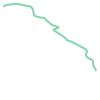

In [40]:
# Shortest path example
display(shortest_paths[(shortest_paths.stop_id_start=="IDFM:21784") & (shortest_paths.stop_id_end=="IDFM:22096")])
shortest_paths[(shortest_paths.stop_id_start=="IDFM:21784") & (shortest_paths.stop_id_end=="IDFM:22096")].line_geometry.iloc[0]

,stop_id_start,stop_id_end,stop_name_start,stop_name_end,line_short_id,line_name,line_transportation_type,line_geometry
52001,IDFM:463197,IDFM:463160,Gare de Lyon,Châtelet,C01371,METRO 1,METRO,"LINESTRING (2.37377 48.84587, 2.37294 48.84575..."


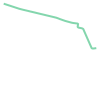

In [41]:
# Shortest path example 2
display(shortest_paths[(shortest_paths.stop_id_start=="IDFM:463197") & (shortest_paths.stop_id_end=="IDFM:463160")])
shortest_paths[(shortest_paths.stop_id_start=="IDFM:463197") & (shortest_paths.stop_id_end=="IDFM:463160")].line_geometry.iloc[0]

### Interpolate each shortest path
This yields interpolated shortest paths with one point every 10 meter.

In [42]:
# Interpolation
from pyproj import Geod
import numpy as np


def interpolate_linestring(line, length, distance_between_points=None):
    if distance_between_points and distance_between_points > 0:
        n = round(length / distance_between_points)
    else:
        n = 10

    interpolation_point_distances = np.linspace(0, line.length, n)
    interpolated_points = [line.interpolate(
        distance) for distance in interpolation_point_distances]
    interpolated_line = LineString(interpolated_points)
    return interpolated_line


DISTANCE_BETWEEN_POINTS = 40  # in meters

shortest_paths['line_geometry_length'] = shortest_paths.line_geometry.to_crs(
    3857).length


shortest_paths['line_geometry_interpolated'] = shortest_paths.apply(lambda x: interpolate_linestring(x.line_geometry,
                                                                                                     x.line_geometry_length,
                                                                                                     distance_between_points=DISTANCE_BETWEEN_POINTS),
                                                                    axis=1)

# Save computed data

The project uses parquet files, which are faster and lighter than GeoPackage or GeoJSON.

In [43]:
# Saving data to parquet files

import os
save_directory = os.path.join('data', 'shortest_paths')
if not os.path.exists(save_directory):
    os.mkdir(save_directory)

print("Saving network and stops DataFrames")
stops.to_parquet(os.path.join('data', "stops.parquet"))
network.to_parquet(os.path.join('data', "network.parquet"))

for line_id in lines:
    print(f"Saving shortest paths for line {line_id}")
    # file_path_gpkg = os.path.join(save_directory, f"{line_id}.gpkg")
    file_path_parquet = os.path.join(save_directory, f"{line_id}.parquet")
    export_df = shortest_paths[shortest_paths.line_short_id == line_id].drop(['line_geometry'], axis=1).set_geometry(
        'line_geometry_interpolated')
    export_df.to_parquet(file_path_parquet)

Saving network and stops DataFrames
Saving shortest paths for line C01371
Saving shortest paths for line C01372
Saving shortest paths for line C01373
Saving shortest paths for line C01374
Saving shortest paths for line C01375
Saving shortest paths for line C01376
Saving shortest paths for line C01377
Saving shortest paths for line C01378
Saving shortest paths for line C01379
Saving shortest paths for line C01380
Saving shortest paths for line C01381
Saving shortest paths for line C01382
Saving shortest paths for line C01383
Saving shortest paths for line C01384
Saving shortest paths for line C01386
Saving shortest paths for line C01387
Saving shortest paths for line C01389
Saving shortest paths for line C01390
Saving shortest paths for line C01391
Saving shortest paths for line C01679
Saving shortest paths for line C01684
Saving shortest paths for line C01727
Saving shortest paths for line C01728
Saving shortest paths for line C01729
Saving shortest paths for line C01730
Saving shortes